# Visualization

### a. Height VS Aces Visualization

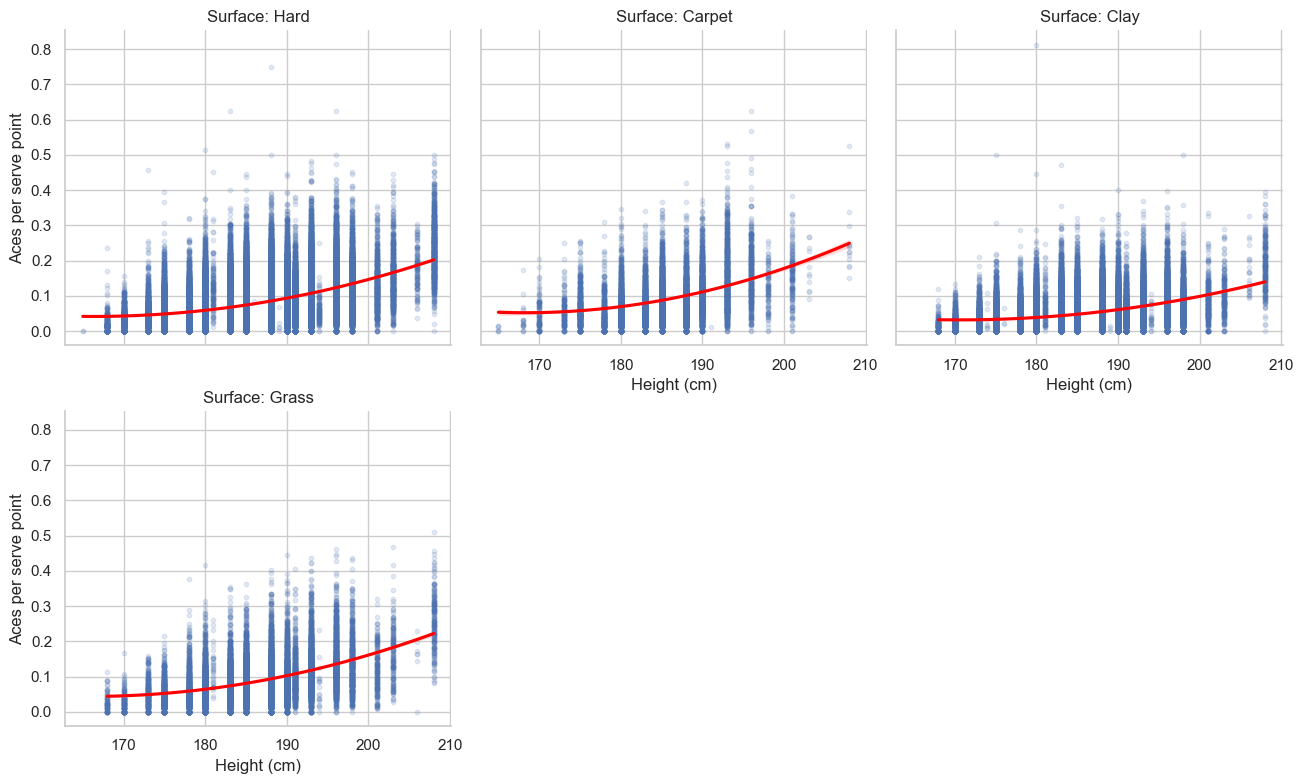

In [25]:
# Height vs Aces visualization

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt



# Load data

df = pd.read_csv('filtered_data.csv')



# Prepare long-form dataset: one row per player-match serving stats

winner_cols = {

    'player_id': 'winner_id',

    'height_cm': 'winner_ht',

    'aces': 'w_ace',

    'svpt': 'w_svpt',

    'surface': 'surface',

    'tourney_date': 'tourney_date'

}



loser_cols = {

    'player_id': 'loser_id',

    'height_cm': 'loser_ht',

    'aces': 'l_ace',

    'svpt': 'l_svpt',

    'surface': 'surface',

    'tourney_date': 'tourney_date'

}



winner_df = df[list(winner_cols.values())].rename(columns={v: k for k, v in winner_cols.items()})

loser_df = df[list(loser_cols.values())].rename(columns={v: k for k, v in loser_cols.items()})



long_df = pd.concat([winner_df, loser_df], ignore_index=True)



# Basic cleaning

long_df = long_df.dropna(subset=['height_cm', 'aces', 'svpt'])

long_df = long_df[long_df['svpt'] > 0]



# Compute aces per serve point

long_df['aces_per_svpt'] = long_df['aces'] / long_df['svpt']



# Optional: filter unrealistic heights

long_df = long_df[(long_df['height_cm'] >= 165) & (long_df['height_cm'] <= 210)]



# Convert tourney_date to year (YYYY) if numeric like 19920106

def extract_year(val):

    try:

        return int(str(int(val))[:4])

    except Exception:

        return pd.NA



long_df['year'] = long_df['tourney_date'].apply(extract_year)



# Plot: Height vs Aces per Serve Point, faceted by surface

sns.set(style='whitegrid')



plot_df = long_df.copy()



g = sns.lmplot(

    data=plot_df,

    x='height_cm',

    y='aces_per_svpt',

    hue=None,

    col='surface',

    col_wrap=3,

    scatter_kws={'alpha': 0.15, 's': 10},

    line_kws={'color': 'red'},

    order=2,

    height=4,

    aspect=1.1

)



g.set_axis_labels('Height (cm)', 'Aces per serve point')

g.set_titles('Surface: {col_name}')



plt.tight_layout()

plt.show()

### b. Best doubles in visualization (percent and matches won)

C:\Users\sanke\AppData\Local\Temp\ipykernel_5288\2299065717.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_winpct, x='team_label', y='win_pct', palette='Blues_d')


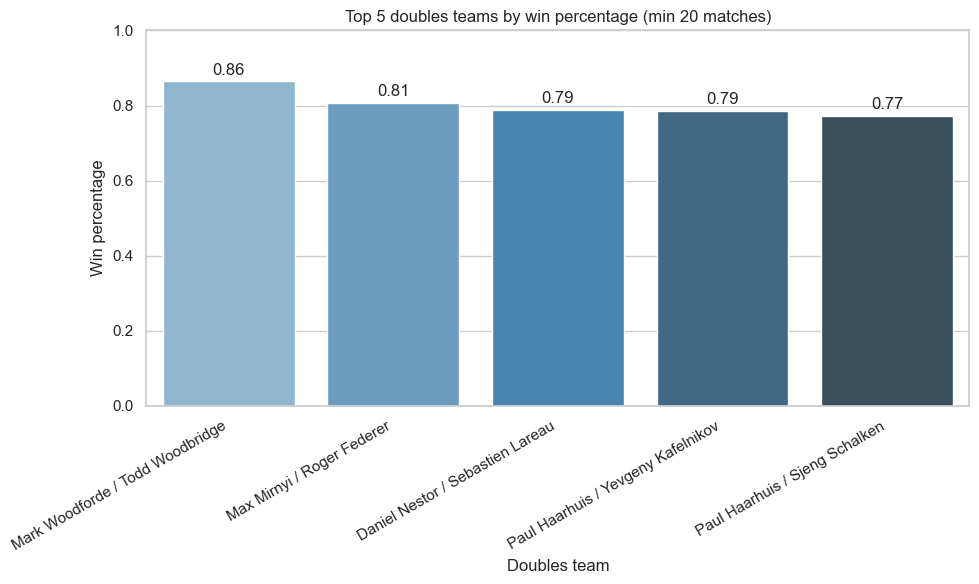

C:\Users\sanke\AppData\Local\Temp\ipykernel_5288\2299065717.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_wins, x='team_label', y='matches_won', palette='Greens_d')


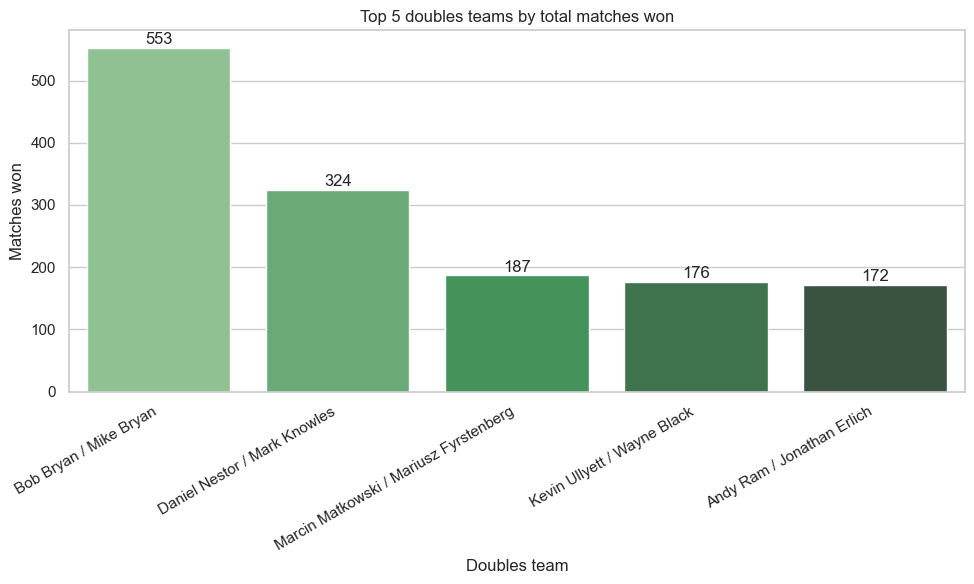

In [26]:
# Best doubles teams: compute matches played and matches won per pair,
# then visualize top 5 by win% and by matches won.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Concatenate all doubles CSVs into a single DataFrame

doubles_files = [
    'Data/Doubles/atp_matches_doubles_2000.csv',
    'Data/Doubles/atp_matches_doubles_2001.csv',
    'Data/Doubles/atp_matches_doubles_2002.csv',
    'Data/Doubles/atp_matches_doubles_2003.csv',
    'Data/Doubles/atp_matches_doubles_2004.csv',
    'Data/Doubles/atp_matches_doubles_2005.csv',
    'Data/Doubles/atp_matches_doubles_2006.csv',
    'Data/Doubles/atp_matches_doubles_2007.csv',
    'Data/Doubles/atp_matches_doubles_2008.csv',
    'Data/Doubles/atp_matches_doubles_2009.csv',
    'Data/Doubles/atp_matches_doubles_2010.csv',
    'Data/Doubles/atp_matches_doubles_2011.csv',
    'Data/Doubles/atp_matches_doubles_2012.csv',
    'Data/Doubles/atp_matches_doubles_2013.csv',
    'Data/Doubles/atp_matches_doubles_2014.csv',
    'Data/Doubles/atp_matches_doubles_2015.csv',
    'Data/Doubles/atp_matches_doubles_2016.csv',
    'Data/Doubles/atp_matches_doubles_2017.csv',
    'Data/Doubles/atp_matches_doubles_2018.csv',
    'Data/Doubles/atp_matches_doubles_2019.csv',
    'Data/Doubles/atp_matches_doubles_2020.csv',
]

frames = []
for f in doubles_files:
    try:
        frames.append(pd.read_csv(f))
    except FileNotFoundError:
        continue

if not frames:
    raise FileNotFoundError("No doubles match files were found. Check the paths in doubles_files.")

raw_df = pd.concat(frames, ignore_index=True)

# 2. Extract names using the provided positional indices (0-based):
#    17 -> winner1, 22 -> winner2, 27 -> loser1, 32 -> loser2

name_df = raw_df.iloc[:, [17, 22, 27, 32]].copy()
name_df.columns = ['winner1_name', 'winner2_name', 'loser1_name', 'loser2_name']

# Drop any row where a name is missing
name_df = name_df.dropna(subset=['winner1_name', 'winner2_name', 'loser1_name', 'loser2_name'])


# 3. Helper to build a normalized team key / label so order does not matter

def make_team(name1, name2):
    names = sorted([str(name1), str(name2)])
    key = "|".join(names)
    label = f"{names[0]} / {names[1]}"
    return key, label

# 4. Iterate through matches and accumulate matches_played and matches_won

team_stats_dict = {}  # key -> {'label': str, 'matches_played': int, 'matches_won': int}

for _, row in name_df.iterrows():
    # Winner pair
    w_key, w_label = make_team(row['winner1_name'], row['winner2_name'])
    if w_key not in team_stats_dict:
        team_stats_dict[w_key] = {'label': w_label, 'matches_played': 0, 'matches_won': 0}
    team_stats_dict[w_key]['matches_played'] += 1
    team_stats_dict[w_key]['matches_won'] += 1

    # Loser pair
    l_key, l_label = make_team(row['loser1_name'], row['loser2_name'])
    if l_key not in team_stats_dict:
        team_stats_dict[l_key] = {'label': l_label, 'matches_played': 0, 'matches_won': 0}
    team_stats_dict[l_key]['matches_played'] += 1

# 5. Convert accumulated dict to DataFrame and compute win percentage

team_rows = []
for key, vals in team_stats_dict.items():
    played = vals['matches_played']
    won = vals['matches_won']
    win_pct = won / played if played > 0 else 0.0
    team_rows.append({
        'team_key': key,
        'team_label': vals['label'],
        'matches_played': played,
        'matches_won': won,
        'win_pct': win_pct,
    })

team_stats = pd.DataFrame(team_rows)

# 6. Top 5 by win percentage (with a minimum matches threshold)

min_matches = 20

# 8. Visualizations

sns.set(style="whitegrid")

# a) Barplot: Top 5 by win percentage
plt.figure(figsize=(10, 6))
sns.barplot(data=top5_winpct, x='team_label', y='win_pct', palette='Blues_d')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Win percentage')
plt.xlabel('Doubles team')
plt.ylim(0, 1)
plt.title('Top 5 doubles teams by win percentage (min 20 matches)')
for i, r in enumerate(top5_winpct.itertuples()):
    plt.text(i, r.win_pct + 0.01, f"{r.win_pct:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# b) Barplot: Top 5 by matches won
plt.figure(figsize=(10, 6))
sns.barplot(data=top5_wins, x='team_label', y='matches_won', palette='Greens_d')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Matches won')
plt.xlabel('Doubles team')
plt.title('Top 5 doubles teams by total matches won')
for i, r in enumerate(top5_wins.itertuples()):
    plt.text(i, r.matches_won + 1, str(r.matches_won), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ML Analysis:

### a. Predict first serve win percentage

In [27]:
# Simple ML analysis: predict first-serve win percentage

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score



# We reuse the dataframe `df` loaded above from filtered_data.csv



# 1. Build a simple player-match dataset with first-serve stats

winner_fs_cols = {

    'height_cm': 'winner_ht',

    'age': 'winner_age',

    'rank': 'winner_rank',

    'rank_points': 'winner_rank_points',

    'surface': 'surface',

    'tourney_level': 'tourney_level',

    'tourney_date': 'tourney_date',

    'fst_in': 'w_1stIn',

    'fst_won': 'w_1stWon'

}



loser_fs_cols = {

    'height_cm': 'loser_ht',

    'age': 'loser_age',

    'rank': 'loser_rank',

    'rank_points': 'loser_rank_points',

    'surface': 'surface',

    'tourney_level': 'tourney_level',

    'tourney_date': 'tourney_date',

    'fst_in': 'l_1stIn',

    'fst_won': 'l_1stWon'

}



w_fs = df[list(winner_fs_cols.values())].rename(columns={v: k for k, v in winner_fs_cols.items()})

l_fs = df[list(loser_fs_cols.values())].rename(columns={v: k for k, v in loser_fs_cols.items()})



fs_df = pd.concat([w_fs, l_fs], ignore_index=True)



# Drop rows with missing key fields

fs_df = fs_df.dropna(subset=['height_cm', 'age', 'rank', 'rank_points', 'surface', 'tourney_level', 'tourney_date', 'fst_in', 'fst_won'])



# Remove cases with no first serves in

fs_df = fs_df[fs_df['fst_in'] > 0]



# 2. Create target: first-serve win percentage

fs_df['first_serve_win_pct'] = fs_df['fst_won'] / fs_df['fst_in']



# 3. Make a very simple feature set

#    - numeric: height, age, rank, rank_points

#    - plus a basic encoding of surface (Hard=0, Clay=1, Grass=2, other=3)



def encode_surface(s):

    if s == 'Hard':

        return 0

    elif s == 'Clay':

        return 1

    elif s == 'Grass':

        return 2

    else:

        return 3



fs_df['surface_code'] = fs_df['surface'].apply(encode_surface)



feature_cols = ['height_cm', 'age', 'rank', 'rank_points', 'surface_code']

X = fs_df[feature_cols]

y = fs_df['first_serve_win_pct']



# 4. Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# 5. Fit a simple Linear Regression model

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)



# 6. Evaluate the model

y_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)   # classic API

rmse = np.sqrt(mse)                        # convert to RMSE

r2 = r2_score(y_test, y_pred)



print(f"Test RMSE (first-serve win pct): {rmse:.4f}")

print(f"Test R^2: {r2:.3f}")



# 7. Look at the fitted coefficients to see which features matter

print("\nFeature coefficients (Linear Regression):")

for name, coef in zip(feature_cols, lin_reg.coef_):

    print(f"{name}: {coef:.4f}")

print(y_pred)

Test RMSE (first-serve win pct): 0.1002
Test R^2: 0.087

Feature coefficients (Linear Regression):
height_cm: 0.0034
age: 0.0004
rank: -0.0001
rank_points: 0.0000
surface_code: 0.0036
[0.72483045 0.68868784 0.76056209 ... 0.70301061 0.70053405 0.70380668]


### b. Predict whether a match goes to deciding set

In [28]:
# c. Predict whether a match goes to a deciding set (classification)

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score



# Helper: count sets from score string

def count_sets(score_str):

    if isinstance(score_str, float) and np.isnan(score_str):

        return np.nan

    if not isinstance(score_str, str):

        return np.nan

    # Sets are usually separated by spaces

    parts = [p for p in score_str.strip().split(' ') if p]

    return len(parts) if len(parts) > 0 else np.nan



# Build match-level dataset

dec_df = df.copy()

dec_df['num_sets'] = dec_df['score'].apply(count_sets)



# Drop rows with missing num_sets or best_of

dec_df = dec_df.dropna(subset=['num_sets', 'best_of'])



# Target: goes to deciding set? (1 if num_sets == best_of, else 0)

dec_df['deciding_set'] = (dec_df['num_sets'] == dec_df['best_of']).astype(int)



# Simple features: differences in rank, height, age + surface, best_of

dec_df = dec_df.dropna(subset=['winner_rank', 'loser_rank', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age', 'surface', 'best_of'])



dec_df['rank_diff'] = np.abs(dec_df['winner_rank'] - dec_df['loser_rank'])

dec_df['height_diff'] = np.abs(dec_df['winner_ht'] - dec_df['loser_ht'])

dec_df['age_diff'] = np.abs(dec_df['winner_age'] - dec_df['loser_age'])



# Encode surface

dec_df['surface_code'] = dec_df['surface'].apply(encode_surface)



feature_cols_dec = ['rank_diff', 'height_diff', 'age_diff', 'surface_code', 'best_of']

X_dec = dec_df[feature_cols_dec]

y_dec = dec_df['deciding_set']



# Train-test split

X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(X_dec, y_dec, test_size=0.2, random_state=42)



# Logistic Regression classifier

log_reg_dec = LogisticRegression(max_iter=1000)

log_reg_dec.fit(X_train_dec, y_train_dec)



# Evaluate

y_pred_dec = log_reg_dec.predict(X_test_dec)

acc_dec = accuracy_score(y_test_dec, y_pred_dec)



print(f"Accuracy predicting deciding-set matches: {acc_dec:.3f}")



print("\nCoefficients (Logistic Regression for deciding set):")

for name, coef in zip(feature_cols_dec, log_reg_dec.coef_[0]):

    print(f"{name}: {coef:.4f}")


Accuracy predicting deciding-set matches: 0.673

Coefficients (Logistic Regression for deciding set):
rank_diff: -0.0007
height_diff: 0.0011
age_diff: 0.0032
surface_code: -0.0014
best_of: -0.4135


### c. Predict winner using serve performance within the match (uses match info that you will not have)

In [29]:
# d. Predict match winner using serve statistics (classification)

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score



# 1. Build match-level serve features

serve_df = df.copy()



# First-serve win percentage for winner and loser

serve_df = serve_df[(serve_df['w_1stIn'] > 0) & (serve_df['l_1stIn'] > 0)]

serve_df['w_first_pct'] = serve_df['w_1stWon'] / serve_df['w_1stIn']

serve_df['l_first_pct'] = serve_df['l_1stWon'] / serve_df['l_1stIn']



# Approximate second-serve win percentage

serve_df = serve_df[(serve_df['w_svpt'] - serve_df['w_1stIn'] > 0) & (serve_df['l_svpt'] - serve_df['l_1stIn'] > 0)]

serve_df['w_second_in'] = serve_df['w_svpt'] - serve_df['w_1stIn']

serve_df['l_second_in'] = serve_df['l_svpt'] - serve_df['l_1stIn']

serve_df['w_second_pct'] = serve_df['w_2ndWon'] / serve_df['w_second_in']

serve_df['l_second_pct'] = serve_df['l_2ndWon'] / serve_df['l_second_in']



# Differences (winner minus loser)

serve_df['first_diff'] = serve_df['w_first_pct'] - serve_df['l_first_pct']

serve_df['second_diff'] = serve_df['w_second_pct'] - serve_df['l_second_pct']

serve_df['aces_diff'] = serve_df['w_ace'] - serve_df['l_ace']

serve_df['df_diff'] = serve_df['w_df'] - serve_df['l_df']



# Features and target (winner is always label 1 in this row)

feature_cols_win = ['first_diff', 'second_diff', 'aces_diff', 'df_diff']

X_win = serve_df[feature_cols_win]

y_win = np.ones(len(serve_df), dtype=int)  # winner row is always 1



# To create some negative examples (label 0), we flip the perspective: loser as if we swapped players

serve_df_flipped = serve_df.copy()

serve_df_flipped['first_diff'] = -serve_df_flipped['first_diff']

serve_df_flipped['second_diff'] = -serve_df_flipped['second_diff']

serve_df_flipped['aces_diff'] = -serve_df_flipped['aces_diff']

serve_df_flipped['df_diff'] = -serve_df_flipped['df_diff']



X_lose = serve_df_flipped[feature_cols_win]

y_lose = np.zeros(len(serve_df_flipped), dtype=int)



# Combine winner and flipped loser rows

X_match = pd.concat([X_win, X_lose], ignore_index=True)

y_match = np.concatenate([y_win, y_lose])



# 2. Train-test split

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_match, y_match, test_size=0.2, random_state=42)



# 3. Logistic Regression classifier

log_reg_win = LogisticRegression(max_iter=1000)

log_reg_win.fit(X_train_m, y_train_m)



# 4. Evaluate

y_pred_m = log_reg_win.predict(X_test_m)

acc_m = accuracy_score(y_test_m, y_pred_m)



print(f"Accuracy predicting match winner from serve stats: {acc_m:.3f}")



print("\nCoefficients (Logistic Regression for match winner):")

for name, coef in zip(feature_cols_win, log_reg_win.coef_[0]):

    print(f"{name}: {coef:.4f}")


Accuracy predicting match winner from serve stats: 0.910

Coefficients (Logistic Regression for match winner):
first_diff: 22.0535
second_diff: 15.0594
aces_diff: 0.0146
df_diff: -0.0465
